In [30]:
!pip install albumentations imgaug torchvision

In [2]:
!pip install --force-reinstall opencv-python

  Using cached opencv_python-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (62.2 MB)
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.9.0.80
    Uninstalling opencv-python-4.9.0.80:
      Successfully uninstalled opencv-python-4.9.0.80


In [31]:
!apt-get install -y libgl1-mesa-glx libglib2.0.0

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libglib2.0-0-dbg' for regex 'libglib2.0.0'
Note, selecting 'libglib2.0-0' for regex 'libglib2.0.0'
libglib2.0-0 is already the newest version (2.72.4-0ubuntu2.2).
libgl1-mesa-glx is already the newest version (23.0.4-0ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


In [59]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import scipy.io as sio
import imgaug.augmenters as iaa
import numpy as np
import os
import math
import random
from torch import optim
from torchvision.transforms import Resize, Compose
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
import albumentations as A
from torchvision.transforms.functional import resize
import imgaug.augmenters as iaa
#%env CUDA_LAUNCH_BLOCKING=1

In [57]:
from torchvision import transforms
import skimage.transform as sk_transform

class LizardDataset(Dataset):
    def __init__(self, img_dir, label_dir, augmented_img_dir, augmented_label_dir, transform=None):
        self.img_dir = img_dir
        self.img_list = os.listdir(img_dir)
        self.label_dir = label_dir
        self.label_list = os.listdir(label_dir)
        
        self.augmented_img_dir = augmented_img_dir
        self.augmented_img_list = []
        self.augmented_label_dir = augmented_label_dir
        self.augmented_label_list = []
        
        self.augmentData()
        
        self.transform = transform

         # Load and preprocess the first image to calculate mean and std
        first_img_path = os.path.join(self.img_dir, self.img_list[0])
        first_img = Image.open(first_img_path).convert('RGB')
        self.mean, self.std = self.calculate_mean_std(first_img)

        # Define the color normalization transform
        self.color_norm = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=self.mean, std=self.std)
        ])

    def augmentData(self):
        for file_name in os.listdir(self.augmented_img_dir):
            os.remove(os.path.join(self.augmented_img_dir, file_name))
            
        for file_name in os.listdir(self.augmented_label_dir):
            os.remove(os.path.join(self.augmented_label_dir, file_name))
        
        seq = iaa.Sequential([
            iaa.Affine(rotate=(-45, 45)),
            iaa.Affine(scale=(0.8, 1.2)),
            iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
        ])
        
        ratio = 0.2
        augmented_count = math.floor(len(self.img_list) * ratio)

        for i in range(augmented_count):
            # pick random index
            idx = random.randint(0, len(self.img_list) - 1)

            # augment image
            img_path = os.path.join(self.img_dir, self.img_list[idx])
            img = Image.open(img_path).convert('RGB')
            
            img = np.array(img)
            augmented_img = seq.augment_image(img)
            augmented_img = Image.fromarray(np.uint8(augmented_img))
            
            augmented_img_path = os.path.join(self.augmented_img_dir, f"augmented_{i}.jpg")
            augmented_img.save(augmented_img_path)
            self.augmented_img_list.append(augmented_img_path)

            # augment label
            label_path = os.path.join(self.label_dir, self.label_list[idx])
            label = sio.loadmat(label_path)
            
            inst_map = label['inst_map']
            inst_map = seq.augment_image(inst_map)
            label['inst_map'] = inst_map
            
            augmented_label_path = os.path.join(self.augmented_label_dir, f"augmented_{i}.mat")
            sio.savemat(augmented_label_path, label)
            self.augmented_label_list.append(augmented_label_path)

    
    def calculate_mean_std(self, img):
        img_array = np.array(img) / 255.0  # Normalize pixel values to range [0, 1]
        mean = np.mean(img_array, axis=(0, 1))
        std = np.std(img_array, axis=(0, 1))
        return mean.tolist(), std.tolist()

    def __len__(self):
        return len(self.img_list) + len(self.augmented_img_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        if (idx < len(self.img_list)):
            img_path = os.path.join(self.img_dir, self.img_list[idx])
            label_path = os.path.join(self.label_dir, self.label_list[idx])
        else:
            img_path = os.path.join(self.augmented_img_dir, self.augmented_img_list[idx-len(self.img_list)])
            label_path = os.path.join(self.augmented_label_dir, self.augmented_label_list[idx-len(self.img_list)])
            
        img = Image.open(img_path)
        img = self.color_norm(img)
        
        # Apply transforms if any
        if self.transform:
            img = self.transform(img)

        # Load label
        label = sio.loadmat(label_path)

        # Load instance segmentation map, the index array, the nuclear categories / classes
        inst_map = label['inst_map']
        nuclei_id = label['id']
        classes = label['class']
        
        # Define function to create class map
        def create_class_map(inst_map, nuclei_id, classes):
            class_map = np.zeros_like(inst_map)  # Initialize class_map with zeros. Same shape as inst_map
            nuclei_id_list = np.squeeze(nuclei_id).tolist()  # Convert nuclei_id to list
            for inst_id, class_id in zip(nuclei_id_list, classes):  # Map each nucleus to its corresponding class
                class_map[inst_map == inst_id] = class_id
            return class_map

        # Create class map
        class_map = create_class_map(inst_map, nuclei_id, classes)
        class_map = sk_transform.resize(class_map, (img.shape[1], img.shape[2]), anti_aliasing=False, order=0, preserve_range=True)
        
        sample = {'image': img, 'inst_map': class_map}
        return sample
        
    def visualize_segmentation_map(self, idx):
        sample = self.__getitem__(idx)
        inst_map = sample['inst_map']

        # Visualize segmentation map
        plt.imshow(inst_map)
        plt.title('Instance Segmentation Map')
        plt.colorbar()
        plt.show()

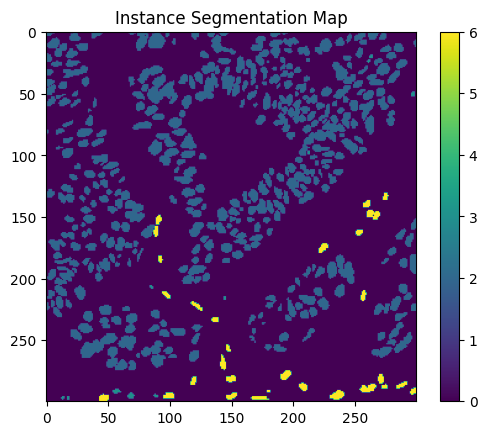

In [58]:
# Create a dataset
img_transforms = transforms.Compose([
    transforms.Resize((300, 300)),  # Ensure consistent resizing
])

full_dataset = LizardDataset(img_dir='../data/images', augmented_img_dir='../data/augmented_images', augmented_label_dir='../data/augmented_labels', label_dir='../data/labels', transform=img_transforms)
full_dataset.visualize_segmentation_map(0)
# Calculate lengths of splits
total_len = len(full_dataset)
train_len = int(0.8 * total_len)
valid_len = int(0.1 * total_len)
test_len = total_len - train_len - valid_len

# Splitting the dataset
train_data, val_data, test_data = random_split(full_dataset, lengths=[train_len, valid_len, test_len])

# Loading the datasets into dataloader
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [10]:


def double_convolution(in_channels, out_channels):
    conv_op = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )
    return conv_op


def crop_tensor(src_tensor, target_tensor):
    target_size = target_tensor.size()[2:]
    src_size = src_tensor.size()[2:]
    crop_left = (src_size[1] - target_size[1]) // 2
    crop_top = (src_size[0] - target_size[0]) // 2
    return src_tensor[..., crop_top:crop_top + target_size[0], crop_left:crop_left + target_size[1]]


class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_convolution_1 = double_convolution(3, 64)
        self.down_convolution_2 = double_convolution(64, 128)
        self.down_convolution_3 = double_convolution(128, 256)
        self.down_convolution_4 = double_convolution(256, 512)
        
        self.up_transpose_1 = nn.ConvTranspose2d(in_channels=512, out_channels=256,kernel_size=2, stride=2)
        self.up_convolution_1 = double_convolution(512, 256)
        
        self.up_transpose_2 = nn.ConvTranspose2d(in_channels=256, out_channels=128,kernel_size=2, stride=2)
        self.up_convolution_2 = double_convolution(256, 128)
        
        self.up_transpose_3 = nn.ConvTranspose2d(in_channels=128, out_channels=64,kernel_size=2, stride=2)
        self.up_convolution_3 = double_convolution(128, 64)
        
        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1) 

    def forward(self, x):
        down_1 = self.down_convolution_1(x)
        down_2 = self.max_pool2d(down_1)
        down_3 = self.down_convolution_2(down_2)
        down_4 = self.max_pool2d(down_3)
        down_5 = self.down_convolution_3(down_4)
        down_6 = self.max_pool2d(down_5)
        down_7 = self.down_convolution_4(down_6)

        up_1 = self.up_transpose_1(down_7)
        down_5 = crop_tensor(down_5, up_1)
        x = self.up_convolution_1(torch.cat([down_5, up_1], 1))
        up_2 = self.up_transpose_2(x)
        down_3 = crop_tensor(down_3, up_2)
        x = self.up_convolution_2(torch.cat([down_3, up_2], 1))
        up_3 = self.up_transpose_3(x)
        down_1 = crop_tensor(down_1, up_3)
        x = self.up_convolution_3(torch.cat([down_1, up_3], 1))
        out = self.out(x)
        return out

In [11]:


def double_convolution_dilated(in_channels, out_channels):
    conv_op = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1,dilation=2),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1,dilation=2),
        nn.ReLU(inplace=True)
    )
    return conv_op


class DilatedUNet(nn.Module):
    def __init__(self, num_classes):
        super(DilatedUNet, self).__init__()
        self.num_classes = num_classes
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_convolution_1 = double_convolution_dilated(3, 64)
        self.down_convolution_2 = double_convolution_dilated(64, 128)
        self.down_convolution_3 = double_convolution_dilated(128, 256)
        self.down_convolution_4 = double_convolution_dilated(256, 512)

        
        self.up_transpose_1 = nn.ConvTranspose2d(in_channels=512, out_channels=256,kernel_size=2,stride=2)
        self.up_convolution_1 = double_convolution_dilated(512, 256)
        
        self.up_transpose_2 = nn.ConvTranspose2d(in_channels=256, out_channels=128,kernel_size=2, stride=2)
        self.up_convolution_2 = double_convolution_dilated(256, 128)
        
        self.up_transpose_3 = nn.ConvTranspose2d(in_channels=128, out_channels=64,kernel_size=2, stride=2)
        self.up_convolution_3 = double_convolution_dilated(128, 64)
        
        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1) 

    def forward(self, x):
        down_1 = self.down_convolution_1(x)
        down_2 = self.max_pool2d(down_1)
        down_3 = self.down_convolution_2(down_2)
        down_4 = self.max_pool2d(down_3)
        down_5 = self.down_convolution_3(down_4)
        down_6 = self.max_pool2d(down_5)
        down_7 = self.down_convolution_4(down_6)

        up_1 = self.up_transpose_1(down_7)
        down_5 = crop_tensor(down_5, up_1)
        x = self.up_convolution_1(torch.cat([down_5, up_1], 1))
        up_2 = self.up_transpose_2(x)
        down_3 = crop_tensor(down_3, up_2)
        x = self.up_convolution_2(torch.cat([down_3, up_2], 1))
        up_3 = self.up_transpose_3(x)
        down_1 = crop_tensor(down_1, up_3)
        x = self.up_convolution_3(torch.cat([down_1, up_3], 1))
        out = self.out(x)
        return out

In [12]:
def dice_score(outputs, labels):
    smooth = 1e-6
    outputs = torch.sigmoid(outputs)
    intersection = torch.sum(outputs * labels)
    union = torch.sum(outputs) + torch.sum(labels)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.item()

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for i, batch in enumerate(train_loader):
            inputs = batch['image'].to(device)
            labels = batch['inst_map']
            
            optimizer.zero_grad()
            outputs = model(inputs)
            labels = F.interpolate(labels.unsqueeze(1).float(), size=outputs.shape[2:]).long().squeeze(1).to(device)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_losses.append(train_loss)

            _, predicted_train = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

            # Calculate batch-wise accuracy
            batch_accuracy = (predicted_train == labels).sum().item() / labels.size(0)

            print(f"Epoch {epoch + 1}/{num_epochs}, Batch {i + 1}/{len(train_loader)}, Loss: {loss.item():.4f}, Batch Acc: {batch_accuracy:.4f}")
            
        # Calculate train accuracy
        train_accuracy = correct_train / total_train
        train_accuracies-append(train_accuracy)

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs = batch['image'].to(device)
                labels = batch['inst_map'].to(device)

                outputs = model(inputs)
                labels = F.interpolate(labels.unsqueeze(1).float(), size=outputs.shape[2:]).long().squeeze(1)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted_val = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
        
    print("Training complete.")

    # Plot training statistics at the end
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()



In [ ]:
# Initialize models
dilated_unet_model = DilatedUNet(7)
unet_model = UNet(7)

# Define data loaders (train_loader, val_loader)
# Assuming you already have them defined

# Train Dilated UNet model
print("Training Dilated UNet model...")
train_model(dilated_unet_model, train_loader, val_loader)

# Train UNet model
print("Training UNet model...")
train_model(unet_model, train_loader, val_loader)

Training Dilated UNet model...
Epoch 1/10, Batch 1/6, Loss: 1.9685, Batch Acc: 1399.8125
Epoch 1/10, Batch 2/6, Loss: 1.8920, Batch Acc: 9557.4688
Epoch 1/10, Batch 3/6, Loss: 1.6862, Batch Acc: 37269.0938
Epoch 1/10, Batch 4/6, Loss: 0.7522, Batch Acc: 37541.3750
Epoch 1/10, Batch 5/6, Loss: 23.0499, Batch Acc: 37205.7812
Epoch 1/10, Batch 6/6, Loss: 1.0066, Batch Acc: 37113.9333
Epoch 1/10, Train Loss: 5.0592, Train Acc: 26571.4263, Val Loss: 1.1953, Val Acc: 38057.2174
Epoch 2/10, Batch 1/6, Loss: 1.1725, Batch Acc: 37706.7812
Epoch 2/10, Batch 2/6, Loss: 1.4495, Batch Acc: 37868.7500
Epoch 2/10, Batch 3/6, Loss: 1.5256, Batch Acc: 37002.5938
Epoch 2/10, Batch 4/6, Loss: 1.5904, Batch Acc: 37698.4062
Epoch 2/10, Batch 5/6, Loss: 1.6355, Batch Acc: 37039.8750
